In [1]:
import copy
import math
import warnings
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.checkpoint import checkpoint

In [2]:
class SwitchTransformersTop1Router(nn.Module):
    """
    Router using tokens choose top-1 experts assignment.
    This router uses the same mechanism as in Switch Transformer (https://arxiv.org/abs/2101.03961) and V-MoE
    (https://arxiv.org/abs/2106.05974): tokens choose their top experts. Items are sorted by router_probs and then
    routed to their choice of expert until the expert's expert_capacity is reached. **There is no guarantee that each
    token is processed by an expert**, or that each expert receives at least one token.
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, router_dtype):
        super().__init__()
        self.num_experts = num_experts
        self.expert_capacity = experts_capacity
        self.classifier = nn.Linear(hidden_size, num_experts, bias=router_bias)
        self.jitter_noise = router_jitter_noise
        self.ignore_padding_tokens = router_ignore_padding_tokens
        self.dtype = getattr(torch, router_dtype)

    def _compute_router_probabilities(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Computes router probabilities from input hidden states.
        Args:
            hidden_states (`torch.Tensor`):
                (batch_size, sequence_length, hidden_dim) from which router probabilities are computed.
        Returns:
            router_probabilities (`torch.Tensor`):
                Tensor of shape (batch_size, sequence_length, num_experts) corresponding to the probabilities for each
                token and expert. Used for routing tokens to experts.
            router_logits (`torch.Tensor`):
                Logits tensor of shape (batch_size, sequence_length, num_experts) corresponding to raw router logits.
                This is used later for computing router z-loss.
        """
        # float32 is used to ensure stability. See the discussion of "selective precision" in
        # https://arxiv.org/abs/2101.03961.
        # We also store the previous dtype to cast back the output to the previous dtype
        self.input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(self.dtype)

        if self.jitter_noise > 0:
            # Get the lower and upper bound of the uniform distribution
            # Adapted from: https://stackoverflow.com/questions/44328530/how-to-get-a-uniform-distribution-in-a-range-r1-r2-in-pytorch
            distrib_lower_bound = 1.0 - self.jitter_noise
            distrib_upper_bound = 1.0 + self.jitter_noise

            uniform_distrib = torch.rand(hidden_states.shape, device=hidden_states.device, dtype=self.dtype)
            uniform_distrib = uniform_distrib * (distrib_lower_bound - distrib_upper_bound)

            uniform_distrib = uniform_distrib + distrib_upper_bound
            # Multiply the token inputs by the uniform distribution - adding some noise
            hidden_states *= uniform_distrib

        # Shape: [num_groups, tokens_per_group, num_experts]
        self._cast_classifier()
        router_logits = self.classifier(hidden_states)

        # Apply Softmax and cast back to the original `dtype`
        router_probabilities = nn.functional.softmax(router_logits, dim=-1, dtype=self.dtype).to(self.input_dtype)
        return router_probabilities, router_logits

    def _cast_classifier(self):
        r"""
        `bitsandbytes` `Linear8bitLt` layers does not support manual casting Therefore we need to check if they are an
        instance of the `Linear8bitLt` class by checking special attributes.
        """
        if not (hasattr(self.classifier, "SCB") or hasattr(self.classifier, "CB")):
            self.classifier = self.classifier.to(self.dtype)

    def forward(self, hidden_states: torch.Tensor) -> Tuple:
        r"""
        Generic forward function for every Router class. Each Router expects to have the same input hidden states
        (`hidden_states`) corresponding to the hidden states for each token, the `expert_capacity` corresponding to the
        number of tokens the Router will send to each expert, some Routers can send up to few tokens to each expert.
        Each Router works as the following: it expects the hidden states for each token, gets the `router_probs` and
        `router_logits` from the `router_weights`. This will assign for each token, the raw probability to be assigned
        to an expert. Then each Router class will have to define its own `_compute_routing_instructions`.
        Args:
            hidden_states (`torch.Tensor`) :
                [num_groups, tokens_per_group, hidden_dim] inputs to send to experts.
        Returns:
            Tuple[`torch.Tensor`, `torch.Tensor`, `torch.Tensor`] Tuple containing the expert index, the router probs
            and the router logits. The router probabilities and logits are required to compute the loss.
        """
        router_probs, router_logits = self._compute_router_probabilities(hidden_states)

        expert_index = torch.argmax(router_probs, dim=-1)
        expert_index = torch.nn.functional.one_hot(expert_index, num_classes=self.num_experts)

        # Mask tokens outside expert capacity. Sum over each sequence
        token_priority = torch.cumsum(expert_index, dim=-2)
        # mask if the token routed to to the expert will overflow
        expert_capacity_mask = token_priority <= self.expert_capacity
        expert_index = expert_index * expert_capacity_mask

        router_probs = torch.max(router_probs, dim=-1).values.unsqueeze(-1)
        return expert_index, router_probs, router_logits

In [3]:
class SwitchTransformersLayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Construct a layernorm module in the SwitchTransformers style. No bias and no subtraction of mean.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        # SwitchTransformers uses a layer_norm which only scales and doesn't shift, which is also known as Root Mean
        # Square Layer Normalization https://arxiv.org/abs/1910.07467 thus varience is calculated
        # w/o mean and there is no bias. Additionally we want to make sure that the accumulation for
        # half-precision inputs is done in fp32

        variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)

        # convert into half-precision if necessary
        if self.weight.dtype in [torch.float16, torch.bfloat16]:
            hidden_states = hidden_states.to(self.weight.dtype)

        return self.weight * hidden_states

In [4]:
class SwitchTransformersDenseActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate, dense_act_fn):
        super().__init__()
        self.wi = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        if dense_act_fn == "gelu":
            self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states)
        if (
            isinstance(self.wo.weight, torch.Tensor)
            and hidden_states.dtype != self.wo.weight.dtype
            and self.wo.weight.dtype != torch.int8
        ):
            hidden_states = hidden_states.to(self.wo.weight.dtype)
        hidden_states = self.wo(hidden_states)
        return hidden_states

In [5]:
class SwitchTransformersDenseGatedActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate, dense_act_fn):
        super().__init__()
        self.wi_0 = nn.Linear(d_model, d_ff, bias=False)
        self.wi_1 = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        if dense_act_fn == "gelu":
            self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.wo(hidden_states)
        return hidden_states


In [6]:
class SwitchTransformersSparseMLP(nn.Module):
    r"""
    Implementation of the Switch Transformers Sparse MLP module.
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, expert_class: nn.Module = SwitchTransformersDenseActDense):        
        super().__init__()
        # Step 1: Get the correct router according to its class
        self.router = SwitchTransformersTop1Router(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                                                   router_ignore_padding_tokens, router_dtype)

        # Step 2: Get the experts
        self.experts = nn.ModuleDict()
        for idx in range(num_experts):
            self.experts[f"expert_{idx}"] = expert_class(d_model, d_ff, dropout_rate, dense_act_fn)

    def forward(self, hidden_states):
        r"""
        Hold on, this will be slightly tricky to understand In the correct order, a MoE layer does the following:
        1- Gets the `router_mask` from the router. The shape of the mask is `(batch_size, sequence_length, num_expert)`
        and corresponds to the argmax of the `router_probs`. The probabilities are needed in the computation of the
        hidden states : they are broadcasted to the hidden states values (can be interpreted as a scaling factor).
        2- Dispatch the tokens to its associated experts. We do a classic for loop over the experts and assign for each
        expert the corresponding hidden states.
        """
        # Step 1: Get the router_mask from the router as wel as the probabilities
        router_mask, router_probs, router_logits = self.router(hidden_states)
        expert_index = torch.argmax(router_mask, dim=-1)

        # The routers introduced might not always map all the tokens, to a router, which means that some hidden states
        # can be unchanged from one layer to another. That is why the hidden states are cloned before updating only the seleced ones.

        next_states = hidden_states.clone()
        for idx, expert in enumerate(self.experts.values()):
            token_indices = router_mask[:, :, idx].bool()
            next_states[token_indices] = expert(hidden_states[token_indices])

        hidden_states = router_probs * next_states
        return hidden_states, (router_logits, expert_index)

In [7]:
class SwitchTransformersLayerFF(nn.Module):
    r"""
    Switch Transformers Feed Forward layer module. This is a wrapper around the Mixture of Experts module.
    Parameters:
        config : ([`SwitchTransformersConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
        is_sparse (`bool`):
            Whether the MLP layer is a `Sparse` layer (contains a Mixture of Experts) or not
    """

    def __init__(self, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, layer_norm_epsilon, is_sparse=False):
        super().__init__()
        self.is_sparse = is_sparse

        # Check if it is a sparse layer, if not then it is a dense layer
        if not self.is_sparse:
            self.mlp = SwitchTransformersDenseActDense(d_model, d_ff, dropout_rate, dense_act_fn)
        else:
            self.mlp = SwitchTransformersSparseMLP(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_model, d_ff, dropout_rate, dense_act_fn)

        self.layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, hidden_states, output_router_logits):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.mlp(forwarded_states)

        if isinstance(forwarded_states, tuple):
            forwarded_states, router_tuple = forwarded_states
        else:
            router_tuple = None

        output = hidden_states + self.dropout(forwarded_states)

        if output_router_logits and router_tuple is not None:
            output = (output, router_tuple)
        return output

In [8]:
class SwitchTransformersAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.has_relative_attention_bias = has_relative_attention_bias
        self.relative_attention_num_buckets = relative_attention_num_buckets
        self.relative_attention_max_distance = relative_attention_max_distance
        self.d_model = d_model
        self.key_value_proj_dim = d_kv
        self.n_heads = num_heads
        self.dropout = dropout_rate
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        # Mesh TensorFlow initialization to avoid scaling before softmax
        self.q = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.k = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.v = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.o = nn.Linear(self.inner_dim, self.d_model, bias=False)

        if self.has_relative_attention_bias:
            self.relative_attention_bias = nn.Embedding(self.relative_attention_num_buckets, self.n_heads)
        self.pruned_heads = set()
        self.gradient_checkpointing = False

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.n_heads, self.key_value_proj_dim, self.pruned_heads
        )
        # Prune linear layers
        self.q = prune_linear_layer(self.q, index)
        self.k = prune_linear_layer(self.k, index)
        self.v = prune_linear_layer(self.v, index)
        self.o = prune_linear_layer(self.o, index, dim=1)
        # Update hyper params
        self.n_heads = self.n_heads - len(heads)
        self.inner_dim = self.key_value_proj_dim * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on
        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer
        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
            relative_position = torch.abs(relative_position)
        else:
            relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
        # now relative_position is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length, device=None):
        """Compute binned relative position bias"""
        if device is None:
            device = self.relative_attention_bias.weight.device
        context_position = torch.arange(query_length, dtype=torch.long, device=device)[:, None]
        memory_position = torch.arange(key_length, dtype=torch.long, device=device)[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )
        values = self.relative_attention_bias(relative_position_bucket)  # shape (query_length, key_length, num_heads)
        values = values.permute([2, 0, 1]).unsqueeze(0)  # shape (1, num_heads, query_length, key_length)
        return values

    def forward(
        self,
        hidden_states,
        mask=None,
        key_value_states=None,
        position_bias=None,
        past_key_value=None,
        layer_head_mask=None,
        query_length=None,
        use_cache=False,
        output_attentions=False,
    ):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, seq_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = hidden_states.shape[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert (
                len(past_key_value) == 2
            ), f"past_key_value should have 2 past states: keys and values. Got { len(past_key_value)} past states"
            real_seq_length += past_key_value[0].shape[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else key_value_states.shape[1]

        def shape(states):
            """projection"""
            return states.view(batch_size, -1, self.n_heads, self.key_value_proj_dim).transpose(1, 2)

        def unshape(states):
            """reshape"""
            return states.transpose(1, 2).contiguous().view(batch_size, -1, self.inner_dim)

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))
            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = torch.cat([past_key_value, hidden_states], dim=2)
                elif past_key_value.shape[2] != key_value_states.shape[1]:
                    # checking that the `sequence_length` of the `past_key_value` is the same as
                    # the provided `key_value_states` to support prefix tuning
                    # cross-attn
                    # (batch_size, n_heads, seq_length, dim_per_head)
                    hidden_states = shape(proj_layer(key_value_states))
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query states
        query_states = shape(self.q(hidden_states))  # (batch_size, n_heads, seq_length, dim_per_head)

        # get key/value states
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.v, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # compute scores
        scores = torch.matmul(
            query_states, key_states.transpose(3, 2)
        )  # equivalent of torch.einsum("bnqd,bnkd->bnqk", query_states, key_states), compatible with onnx op>9

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = torch.zeros(
                    (1, self.n_heads, real_seq_length, key_length), device=scores.device, dtype=scores.dtype
                )
                if self.gradient_checkpointing and self.training:
                    position_bias.requires_grad = True
            else:
                position_bias = self.compute_bias(real_seq_length, key_length, device=scores.device)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -hidden_states.size(1) :, :]

            if mask is not None:
                position_bias = position_bias + mask  # (batch_size, n_heads, seq_length, key_length)

        if self.pruned_heads:
            mask = torch.ones(position_bias.shape[1])
            mask[list(self.pruned_heads)] = 0
            position_bias_masked = position_bias[:, mask.bool()]
        else:
            position_bias_masked = position_bias

        scores += position_bias_masked
        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (batch_size, n_heads, seq_length, key_length)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )  # (batch_size, n_heads, seq_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            attn_weights = attn_weights * layer_head_mask

        attn_output = unshape(torch.matmul(attn_weights, value_states))  # (batch_size, seq_length, dim)
        attn_output = self.o(attn_output)

        present_key_value_state = (key_states, value_states) if (self.is_decoder and use_cache) else None
        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (attn_weights,)
        return outputs

In [9]:
class SwitchTransformersLayerSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 layer_norm_epsilon=1e-6, is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.SelfAttention = SwitchTransformersAttention(
            d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate, d_kv=d_kv, 
            relative_attention_num_buckets=relative_attention_num_buckets, relative_attention_max_distance=relative_attention_max_distance, 
            is_decoder=is_decoder, has_relative_attention_bias=has_relative_attention_bias
        )
        self.layer_norm = SwitchTransformersLayerNorm(d_model, layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(
            normed_hidden_states,
            mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0])
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [10]:
class SwitchTransformersLayerCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 layer_norm_epsilon, is_decoder=False, has_relative_attention_bias=False):
        super().__init__()
        self.EncDecAttention = SwitchTransformersAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, has_relative_attention_bias)
        self.layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        key_value_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        query_length=None,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(
            normed_hidden_states,
            mask=attention_mask,
            key_value_states=key_value_states,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            query_length=query_length,
            output_attentions=output_attentions,
        )
        layer_output = hidden_states + self.dropout(attention_output[0])
        outputs = (layer_output,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [11]:
class SwitchTransformersBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, is_decoder=False, has_relative_attention_bias=False, is_sparse=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.is_sparse = is_sparse
        self.layer = nn.ModuleList()
        self.layer.append(
            SwitchTransformersLayerSelfAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, layer_norm_epsilon, is_decoder, has_relative_attention_bias)
        )
        if self.is_decoder:
            self.layer.append(SwitchTransformersLayerCrossAttention(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, layer_norm_epsilon, is_decoder, has_relative_attention_bias))

        self.layer.append(SwitchTransformersLayerFF(hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_model, d_ff, dropout_rate, dense_act_fn, layer_norm_epsilon, self.is_sparse))

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        encoder_decoder_position_bias=None,
        layer_head_mask=None,
        cross_attn_layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        output_router_logits=True,
        return_dict=True,
    ):
        if past_key_value is not None:
            if not self.is_decoder:
                logger.warning("`past_key_values` is passed to the encoder. Please make sure this is intended.")
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention. ' if expected_num_past_key_values == 4 else ''}"
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        do_cross_attention = self.is_decoder and encoder_hidden_states is not None
        if do_cross_attention:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = present_key_value_state[0].shape[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            hidden_states = cross_attention_outputs[0]

            # clamp inf values to enable fp16 training
            if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states, output_router_logits)

        if isinstance(hidden_states, tuple):
            hidden_states, router_tuple = hidden_states
        else:
            router_tuple = (None,)

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if use_cache:
            outputs = outputs + (present_key_value_state,) + attention_outputs + (router_tuple,)           
        else:
            outputs = outputs + attention_outputs + (router_tuple,)

        return outputs  # hidden-states, present_key_value_states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights), (router_tuple)

In [12]:
class SwitchTransformersStack(nn.Module):
    def __init__(self, d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, relative_attention_max_distance, 
                 hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, router_ignore_padding_tokens, 
                 router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, encoder_sparse_step, num_decoder_layers,
                 num_layers, output_attentions, use_cache, output_hidden_states, is_decoder=False, has_relative_attention_bias=False, is_sparse=False, embed_tokens=None):
        super().__init__()

        self.embed_tokens = nn.Embedding(vocab_size, d_model)

        if embed_tokens is not None:
            self.embed_tokens.weight = embed_tokens.weight

        self.is_decoder = is_decoder

        sparse_step = decoder_sparse_step if self.is_decoder else encoder_sparse_step
        num_layers = num_decoder_layers if self.is_decoder else num_layers
        self.block = nn.ModuleList()
        for i in range(num_layers):
            is_sparse = True
            #is_sparse = (i % sparse_step == 1) if sparse_step > 0 else False

            self.block.append(
                SwitchTransformersBlock(d_model, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, is_decoder, 
                 has_relative_attention_bias=bool(i == 0), is_sparse=is_sparse)
            )

        self.final_layer_norm = SwitchTransformersLayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights and apply final processing

        self.device_map = None
        self.gradient_checkpointing = False
        self.use_cache = use_cache
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, new_embeddings):
        self.embed_tokens = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        output_router_logits=True,
        return_dict=None,
    ):
        use_cache = use_cache if use_cache is not None else self.use_cache
           
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size(0), input_ids.size(1)
            input_ids = input_ids.view(input_shape[0], input_shape[1], -1)
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs_embeds is None:
            if self.embed_tokens is None:
                raise ValueError("You have to initialize the model with valid token embeddings")
            inputs_embeds = input_ids

        batch_size, seq_length = input_shape

        # required mask seq length can be calculated via length of past
        mask_seq_length = past_key_values[0][0].shape[2] + seq_length if past_key_values is not None else seq_length

        if use_cache is True:
            if not self.is_decoder:
                raise ValueError(f"`use_cache` can only be set to `True` if {self} is used as a decoder")

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length, device=inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = None
        #extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
            encoder_extended_attention_mask = None
            #encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # Prepare head mask if needed
        head_mask=None
        #head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        cross_attn_head_mask=None
        #cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_router_probs = () if output_router_logits else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
            layer_head_mask = None
            #layer_head_mask = head_mask[i]
            cross_attn_layer_head_mask = None
            #cross_attn_layer_head_mask = cross_attn_head_mask[i]

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    extended_attention_mask,
                    position_bias,
                    encoder_hidden_states,
                    encoder_extended_attention_mask,
                    encoder_decoder_position_bias,
                    layer_head_mask,
                    cross_attn_layer_head_mask,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=extended_attention_mask,
                    position_bias=position_bias,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                    output_router_logits=output_router_logits,
                )

            router_probs = layer_outputs[-1]           
            layer_outputs = layer_outputs[:-1]

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            if self.is_decoder and encoder_hidden_states is not None:
                encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            if output_router_logits:
                all_router_probs = all_router_probs + (router_probs,)

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)
        
        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:         
            return tuple(
                v
                for v in [
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                    all_router_probs,
                ]
                if v is not None
            )

In [13]:
class SwitchTransformersModel(nn.Module):
    def __init__(self, d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
                 encoder_sparse_step, num_decoder_layers, num_layers, num_sparse_encoder_layers):
        super().__init__()
        self.shared = nn.Embedding(vocab_size, d_model)

        self.encoder = SwitchTransformersStack(d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
                 relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
                 router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
                 encoder_sparse_step, num_decoder_layers, num_layers, output_attentions=True, use_cache=False, output_hidden_states=True, 
                 is_decoder=False, has_relative_attention_bias=True, is_sparse=True, embed_tokens=self.shared)

        # Initialize weights and apply final processing

        # Model parallel
        self.device_map = None
        self.use_cache = True
        self.use_return_dict = False
        self.num_sparse_encoder_layers = num_sparse_encoder_layers
        
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(d_model, 1)
        

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)
        self.decoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        decoder_inputs_embeds: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_router_logits: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor]]:
        r"""
        Returns:
        Example:
        ```python
        >>> from transformers import AutoTokenizer, SwitchTransformersModel
        >>> tokenizer = AutoTokenizer.from_pretrained("google/switch-base-8")
        >>> model = SwitchTransformersModel.from_pretrained("google/switch-base-8")
        >>> input_ids = tokenizer(
        ...     "Studies have been shown that owning a dog is good for you", return_tensors="pt"
        ... ).input_ids  # Batch size 1
        >>> decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1
        >>> # preprocess: Prepend decoder_input_ids with start token which is pad token for SwitchTransformersModel.
        >>> # This is not needed for torch's SwitchTransformersForConditionalGeneration as it does this internally using labels arg.
        >>> decoder_input_ids = model._shift_right(decoder_input_ids)
        >>> # forward pass
        >>> outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        >>> last_hidden_states = outputs.last_hidden_state
        ```"""
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.config.num_layers == self.config.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        if (
            output_router_logits
            and self.num_sparse_encoder_layers == 0
            and self.num_sparse_encoder_layers == 0
        ):
            raise ValueError(
                "You asked to return `output_router_logits` but the transformer in dense, and does                    "
                "           not contain any sparse MLP Layers. Set `output_router_logits = False` and restart"
            )
        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                output_router_logits=output_router_logits,
                return_dict=return_dict,
            )
        elif return_dict and not isinstance(encoder_outputs, MoEModelOutput):
            encoder_outputs = MoEModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
                router_probs=encoder_outputs[3] if len(encoder_outputs) > 3 else None,
            )

        output = encoder_outputs[0]
        output = torch.mean(output,dim=1,keepdim=False)
        output = self.final_layer(output)
        
        new_output = (output,) + encoder_outputs[1:]

        if not return_dict:
            return new_output

In [14]:
num_layers = 2
num_decoder_layers = 2
vocab_size = 50
num_heads = 2
d_model = 22
d_ff = 64
dropout_rate = 0
d_kv = 32
relative_attention_num_buckets = 32
relative_attention_max_distance = 128
hidden_size = 22
num_experts = 4
experts_capacity = 10
router_bias = True
router_jitter_noise = 0.01
router_ignore_padding_tokens = True
router_dtype = 'float32'
dense_act_fn = 'gelu'
layer_norm_epsilon = 1e-6
decoder_sparse_step = 2
encoder_sparse_step = 2
num_sparse_encoder_layers = 2

input_ids = torch.rand(5, 20, 22)


model=SwitchTransformersModel(
        d_model, vocab_size, num_heads, dropout_rate, d_kv, relative_attention_num_buckets, 
        relative_attention_max_distance, hidden_size, num_experts, experts_capacity, router_bias, router_jitter_noise, 
        router_ignore_padding_tokens, router_dtype, d_ff, dense_act_fn, layer_norm_epsilon, decoder_sparse_step, 
        encoder_sparse_step, num_decoder_layers, num_layers, num_sparse_encoder_layers
)

In [15]:
hidden_states, all_hidden_states, all_attentions, all_router_probs = model(input_ids=input_ids, output_router_logits=True)
print(hidden_states.shape)
print(hidden_states)

torch.Size([5, 1])
tensor([[0.1847],
        [0.0981],
        [0.2693],
        [0.2326],
        [0.1982]], grad_fn=<AddmmBackward0>)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [18]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [19]:
df_for_training=df[feature_names].astype(float)

In [20]:
df_for_training.shape

(11524, 22)

In [21]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
trainX=[]
trainY=[]

In [23]:
n_future=1
n_past=20

In [24]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [25]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [26]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [27]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [28]:
data,label=random_shuffle(trainX,trainY)

In [29]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [30]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [31]:
label=standardization(label)

In [32]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
criterion = nn.L1Loss()

In [34]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output, all_hidden_states, all_attentions, all_router_probs = model(input_ids=data, output_router_logits=True)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.12958654761314392
Epoch: 1 Loss: 0.1135648712515831
Epoch: 2 Loss: 0.09858696907758713
Epoch: 3 Loss: 0.13622784614562988
Epoch: 4 Loss: 0.18055054545402527
Epoch: 5 Loss: 0.05332184582948685
Epoch: 6 Loss: 0.06522213667631149
Epoch: 7 Loss: 0.06919451802968979
Epoch: 8 Loss: 0.06763219833374023
Epoch: 9 Loss: 0.06524068117141724
Epoch: 10 Loss: 0.06289393454790115
Epoch: 11 Loss: 0.05849632993340492
Epoch: 12 Loss: 0.05814626067876816
Epoch: 13 Loss: 0.05435255914926529
Epoch: 14 Loss: 0.05205545946955681
Epoch: 15 Loss: 0.05156692862510681
Epoch: 16 Loss: 0.049620263278484344
Epoch: 17 Loss: 0.047074802219867706
Epoch: 18 Loss: 0.046462275087833405
Epoch: 19 Loss: 0.04438892379403114
Epoch: 20 Loss: 0.042566120624542236
Epoch: 21 Loss: 0.040199995040893555
Epoch: 22 Loss: 0.03850797563791275
Epoch: 23 Loss: 0.03677066043019295
Epoch: 24 Loss: 0.03390396758913994
Epoch: 25 Loss: 0.03137551248073578
Epoch: 26 Loss: 0.02955540642142296
Epoch: 27 Loss: 0.0297695808112621

Epoch: 222 Loss: 0.026007264852523804
Epoch: 223 Loss: 0.026983896270394325
Epoch: 224 Loss: 0.026436176151037216
Epoch: 225 Loss: 0.024809705093503
Epoch: 226 Loss: 0.026638733223080635
Epoch: 227 Loss: 0.026174675673246384
Epoch: 228 Loss: 0.027108209207654
Epoch: 229 Loss: 0.02743804082274437
Epoch: 230 Loss: 0.022313764318823814
Epoch: 231 Loss: 0.025986095890402794
Epoch: 232 Loss: 0.026313435286283493
Epoch: 233 Loss: 0.022900907322764397
Epoch: 234 Loss: 0.023606743663549423
Epoch: 235 Loss: 0.0237775556743145
Epoch: 236 Loss: 0.025219231843948364
Epoch: 237 Loss: 0.02509988471865654
Epoch: 238 Loss: 0.024314794689416885
Epoch: 239 Loss: 0.024146366864442825
Epoch: 240 Loss: 0.023939162492752075
Epoch: 241 Loss: 0.024544525891542435
Epoch: 242 Loss: 0.02390146255493164
Epoch: 243 Loss: 0.024602321907877922
Epoch: 244 Loss: 0.023289289325475693
Epoch: 245 Loss: 0.024401169270277023
Epoch: 246 Loss: 0.026031190529465675
Epoch: 247 Loss: 0.028289902955293655
Epoch: 248 Loss: 0.0252

Epoch: 441 Loss: 0.01840975321829319
Epoch: 442 Loss: 0.018405253067612648
Epoch: 443 Loss: 0.019088659435510635
Epoch: 444 Loss: 0.0174835417419672
Epoch: 445 Loss: 0.01936245523393154
Epoch: 446 Loss: 0.015125236473977566
Epoch: 447 Loss: 0.017102759331464767
Epoch: 448 Loss: 0.017349135130643845
Epoch: 449 Loss: 0.018426083028316498
Epoch: 450 Loss: 0.01651500165462494
Epoch: 451 Loss: 0.01661863923072815
Epoch: 452 Loss: 0.01705983839929104
Epoch: 453 Loss: 0.01803295500576496
Epoch: 454 Loss: 0.0176558755338192
Epoch: 455 Loss: 0.017203373834490776
Epoch: 456 Loss: 0.019033895805478096
Epoch: 457 Loss: 0.017058568075299263
Epoch: 458 Loss: 0.018636269494891167
Epoch: 459 Loss: 0.0174983199685812
Epoch: 460 Loss: 0.019205421209335327
Epoch: 461 Loss: 0.01821797713637352
Epoch: 462 Loss: 0.017479119822382927
Epoch: 463 Loss: 0.01990286447107792
Epoch: 464 Loss: 0.01631936989724636
Epoch: 465 Loss: 0.01721479929983616
Epoch: 466 Loss: 0.018670853227376938
Epoch: 467 Loss: 0.017838152

Epoch: 660 Loss: 0.0188277754932642
Epoch: 661 Loss: 0.019011126831173897
Epoch: 662 Loss: 0.02701302245259285
Epoch: 663 Loss: 0.010599056258797646
Epoch: 664 Loss: 0.02071552164852619
Epoch: 665 Loss: 0.00835530087351799
Epoch: 666 Loss: 0.019060321152210236
Epoch: 667 Loss: 0.010586176998913288
Epoch: 668 Loss: 0.009386594407260418
Epoch: 669 Loss: 0.008464480750262737
Epoch: 670 Loss: 0.00741173792630434
Epoch: 671 Loss: 0.02520883083343506
Epoch: 672 Loss: 0.011647307313978672
Epoch: 673 Loss: 0.03131795674562454
Epoch: 674 Loss: 0.017142632976174355
Epoch: 675 Loss: 0.02082167938351631
Epoch: 676 Loss: 0.022730465978384018
Epoch: 677 Loss: 0.011888731271028519
Epoch: 678 Loss: 0.028893224895000458
Epoch: 679 Loss: 0.010174315422773361
Epoch: 680 Loss: 0.013045042753219604
Epoch: 681 Loss: 0.012843504548072815
Epoch: 682 Loss: 0.013248482719063759
Epoch: 683 Loss: 0.01462404802441597
Epoch: 684 Loss: 0.01308421790599823
Epoch: 685 Loss: 0.012862476520240307
Epoch: 686 Loss: 0.0129

Epoch: 878 Loss: 0.020132161676883698
Epoch: 879 Loss: 0.023898523300886154
Epoch: 880 Loss: 0.013777248561382294
Epoch: 881 Loss: 0.017710648477077484
Epoch: 882 Loss: 0.00826107244938612
Epoch: 883 Loss: 0.017738010734319687
Epoch: 884 Loss: 0.007819971069693565
Epoch: 885 Loss: 0.02112305909395218
Epoch: 886 Loss: 0.011937081813812256
Epoch: 887 Loss: 0.010317735373973846
Epoch: 888 Loss: 0.011713729240000248
Epoch: 889 Loss: 0.016381215304136276
Epoch: 890 Loss: 0.04251263290643692
Epoch: 891 Loss: 0.02691180258989334
Epoch: 892 Loss: 0.01795419305562973
Epoch: 893 Loss: 0.01775718852877617
Epoch: 894 Loss: 0.01908927410840988
Epoch: 895 Loss: 0.02024148590862751
Epoch: 896 Loss: 0.01587529107928276
Epoch: 897 Loss: 0.018310965970158577
Epoch: 898 Loss: 0.017140332609415054
Epoch: 899 Loss: 0.018917357549071312
Epoch: 900 Loss: 0.0126362144947052
Epoch: 901 Loss: 0.013284318149089813
Epoch: 902 Loss: 0.017868785187602043
Epoch: 903 Loss: 0.023132843896746635
Epoch: 904 Loss: 0.0154

In [35]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [36]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [37]:
trainY_copy_=standardization(trainY_copy_)

In [38]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [39]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output, all_hidden_states, all_attentions, all_router_probs=model(input_ids=data, output_router_logits=True)
    predictions+=output.tolist()

In [40]:
predictions = np.array(predictions)

In [41]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

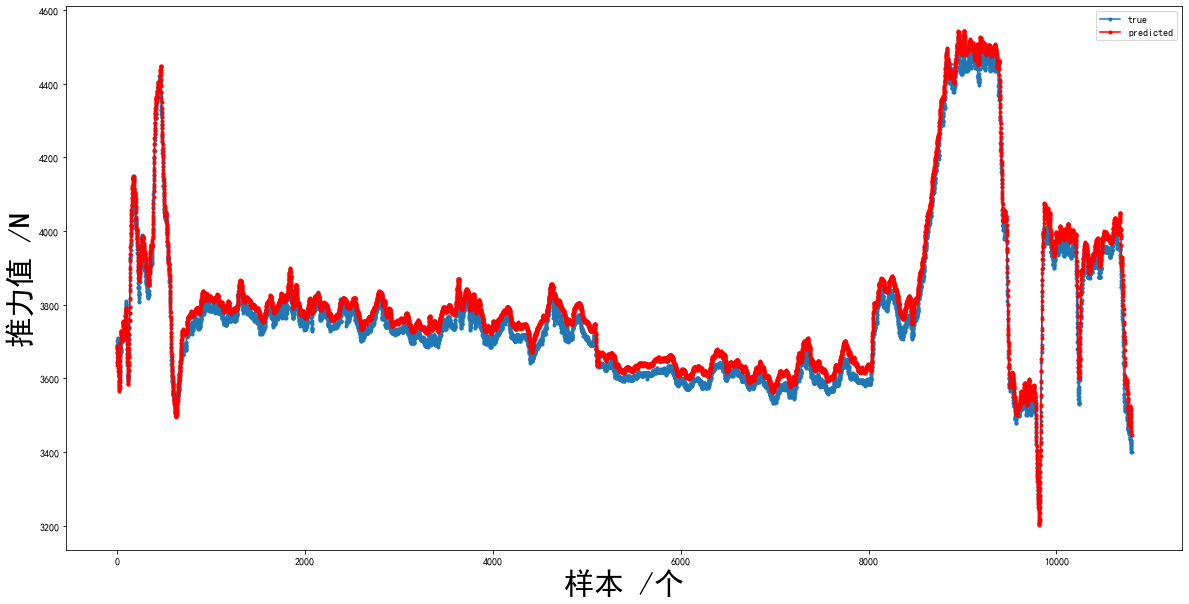

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 